In [211]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [212]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

Building the vocabulary of characters and the mappings to and from char to int

In [213]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Building the Dataset

In [288]:
block_size = 4 # Context length, how many characters are considered to predict the next one.
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [289]:
def build_dataset(words):
    block_size = 4
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [290]:
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([228146, 4]) torch.int64 torch.Size([228146]) torch.int64


## Making the model

In [291]:
Xtr.shape, Ytr.shape # Dataset

(torch.Size([182580, 4]), torch.Size([182580]))

In [306]:
g = torch.Generator().manual_seed(2147483647) # For reproducability
C = torch.randn((27, 10), generator=g) # Table Lookup
W1 = torch.randn((40,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [307]:
sum(p.nelement() for p in parameters) # number of total parameters

13897

In [308]:
for p in parameters:
    p.requires_grad = True

In [309]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [310]:
lri = []
lossi = []
stepi = []

In [311]:
for i in range(200000):
    # Minibatch Construct
    ix = torch.randint(0, Xtr.shape[0], (64,))

    # Forward pass
    emb = C[Xtr[ix]] # (32, 3, 2) Embedding based on C (encoding each character)
    h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100) Hidden layer
    logits = h @ W2 + b2 # (32, 27) 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

Plotting some learning rates to determine a good choice

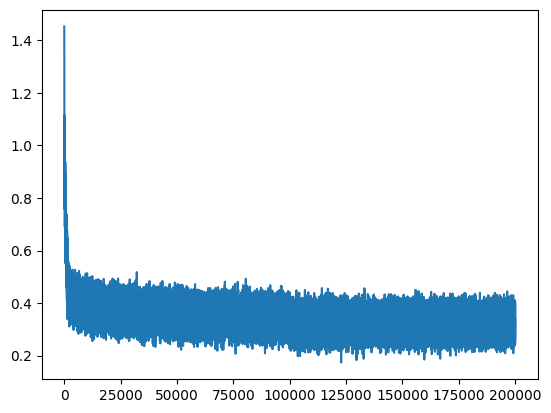

In [312]:
# plt.plot(lri, lossi)
plt.plot(stepi, lossi)


Validation Loss

In [313]:
emb = C[Xval] # (32, 3, 2) Embedding based on C (encoding each character)
h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100) Hidden layer
logits = h @ W2 + b2 # (32, 27) 
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1615, grad_fn=<NllLossBackward0>)

Test Loss

In [314]:
emb = C[Xte] # (32, 3, 2) Embedding based on C (encoding each character)
h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100) Hidden layer
logits = h @ W2 + b2 # (32, 27) 
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1698, grad_fn=<NllLossBackward0>)

Sampling from the model

In [315]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

abebaylan.
kossin.
badrianna.
lyananton.
kastiann.
emamiyah.
essla.
lecpa.
veanna.
hura.
ester.
saena.
sorie.
yonna.
keakailyn.
leya.
sanfai.
johnn.
senzley.
yesten.


Visualizing the Embeddings Before we Scale them

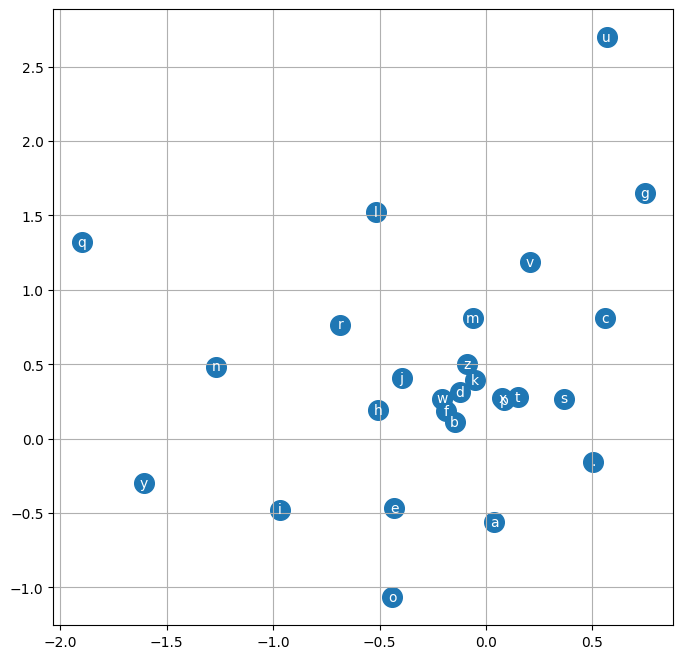

In [237]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')